In [1]:
import tensorflow as tf

In [2]:
from keras.models import Model
from keras.applications import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import cv2
import numpy as np
from os import listdir
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

def cal_accum_avg(frame, accumulated_weight):
    
    global background
    
    if background is None:
        background = frame.copy().astype('float')
        return None
    
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [4]:
def segment_hand(frame, threshold=12):
    global background
    
    diff = cv2.absdiff(background.astype('uint8'), frame)
    
    _, thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(thresholded.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return thresholded, hand_segment_max_cont



In [15]:
cam = cv2.VideoCapture(0)

num_frames = 0
#Tên của cử chỉ muốn lưu
element = 'C'
num_imgs_taken = 0

while True:
    ret, frame = cam.read()
    
    frame = cv2.flip(frame, 1)
    
    frame_copy = frame.copy()
    
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    
    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames < 59:
            cv2.putText(frame_copy, 'FETCHING BACKGROUND...PLEASE WAIT',
                        (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    elif num_frames <= 300:
        hand = segment_hand(gray_frame)
        cv2.putText(frame_copy, 'Adjust hand...Gesture for ' +
  str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
  (0,0,255),2)
        
        if hand is not None:
            
            thresholded, hand_segment = hand
            
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)],
                            -1, (255, 0, 0), 1)
            
            #Hàm đặt chữ vào ảnh từ camera
            cv2.putText(frame_copy, str(num_frames) + ' For ' + element,
            (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.imshow('Thresholded Hand Image', thresholded)
    
                    
    else:
        hand = segment_hand(gray_frame)
        
        if hand is not None:
            
            thresholded, hand_segment = hand
            
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)],
                            -1, (255, 0, 0), 1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.imshow("Thresholded Hand Image", thresholded)
            #Lưu lại 1000 ảnh
            if num_imgs_taken <= 1000:
                cv2.imwrite('D:\\gesture\\train\\' + element +'\\' + str(num_imgs_taken+300) + '.png', thresholded)
            else:
                break
            num_imgs_taken += 1
        
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            
            
    #Hàm vẽ ô vuông để ta đặt đối tượng vào        
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,125,0), 3)  
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    #Số lượng khung hình để dễ theo dõi
    num_frames += 1
    cv2.imshow("Sign Detection", frame_copy)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
cam.release()
    

In [5]:
raw_folder = 'D:\\gesture\\train\\'
def load_data(raw_folder = raw_folder):
    
    print('Images processsing...')
    
    pixels = []
    labels = []
    
    for folder in listdir(raw_folder):
        if folder != '.DS_Store':
            print('Folder = ', folder)
            
            for file in listdir(raw_folder + folder):
                if file != '.DS_Store':
                    print('File = ', file)
                    
                    pixels.append(cv2.resize(cv2.imread(raw_folder + folder + '\\' + file), dsize=(64, 64)))
                    labels.append(folder)
                    
    pixels = np.array(pixels)
    labels = np.array(labels)
    
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    
    return pixels, labels

In [7]:
X, y = load_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=100)
np.shape(X_train)

Images processsing...
Folder =  A
File =  1000.png
File =  1001.png
File =  1002.png
File =  1003.png
File =  1004.png
File =  1005.png
File =  1006.png
File =  1007.png
File =  1008.png
File =  1009.png
File =  1010.png
File =  1011.png
File =  1012.png
File =  1013.png
File =  1014.png
File =  1015.png
File =  1016.png
File =  1017.png
File =  1018.png
File =  1019.png
File =  1020.png
File =  1021.png
File =  1022.png
File =  1023.png
File =  1024.png
File =  1025.png
File =  1026.png
File =  1027.png
File =  1028.png
File =  1029.png
File =  1030.png
File =  1031.png
File =  1032.png
File =  1033.png
File =  1034.png
File =  1035.png
File =  1036.png
File =  1037.png
File =  1038.png
File =  1039.png
File =  1040.png
File =  1041.png
File =  1042.png
File =  1043.png
File =  1044.png
File =  1045.png
File =  1046.png
File =  1047.png
File =  1048.png
File =  1049.png
File =  1050.png
File =  1051.png
File =  1052.png
File =  1053.png
File =  1054.png
File =  1055.png
File =  1056.p

File =  535.png
File =  536.png
File =  537.png
File =  538.png
File =  539.png
File =  540.png
File =  541.png
File =  542.png
File =  543.png
File =  544.png
File =  545.png
File =  546.png
File =  547.png
File =  548.png
File =  549.png
File =  550.png
File =  551.png
File =  552.png
File =  553.png
File =  554.png
File =  555.png
File =  556.png
File =  557.png
File =  558.png
File =  559.png
File =  560.png
File =  561.png
File =  562.png
File =  563.png
File =  564.png
File =  565.png
File =  566.png
File =  567.png
File =  568.png
File =  569.png
File =  570.png
File =  571.png
File =  572.png
File =  573.png
File =  574.png
File =  575.png
File =  576.png
File =  577.png
File =  578.png
File =  579.png
File =  580.png
File =  581.png
File =  582.png
File =  583.png
File =  584.png
File =  585.png
File =  586.png
File =  587.png
File =  588.png
File =  589.png
File =  590.png
File =  591.png
File =  592.png
File =  593.png
File =  594.png
File =  595.png
File =  596.png
File =  

File =  1162.png
File =  1163.png
File =  1164.png
File =  1165.png
File =  1166.png
File =  1167.png
File =  1168.png
File =  1169.png
File =  1170.png
File =  1171.png
File =  1172.png
File =  1173.png
File =  1174.png
File =  1175.png
File =  1176.png
File =  1177.png
File =  1178.png
File =  1179.png
File =  1180.png
File =  1181.png
File =  1182.png
File =  1183.png
File =  1184.png
File =  1185.png
File =  1186.png
File =  1187.png
File =  1188.png
File =  1189.png
File =  1190.png
File =  1191.png
File =  1192.png
File =  1193.png
File =  1194.png
File =  1195.png
File =  1196.png
File =  1197.png
File =  1198.png
File =  1199.png
File =  1200.png
File =  1201.png
File =  1202.png
File =  1203.png
File =  1204.png
File =  1205.png
File =  1206.png
File =  1207.png
File =  1208.png
File =  1209.png
File =  1210.png
File =  1211.png
File =  1212.png
File =  1213.png
File =  1214.png
File =  1215.png
File =  1216.png
File =  1217.png
File =  1218.png
File =  1219.png
File =  1220.p

File =  756.png
File =  757.png
File =  758.png
File =  759.png
File =  760.png
File =  761.png
File =  762.png
File =  763.png
File =  764.png
File =  765.png
File =  766.png
File =  767.png
File =  768.png
File =  769.png
File =  770.png
File =  771.png
File =  772.png
File =  773.png
File =  774.png
File =  775.png
File =  776.png
File =  777.png
File =  778.png
File =  779.png
File =  780.png
File =  781.png
File =  782.png
File =  783.png
File =  784.png
File =  785.png
File =  786.png
File =  787.png
File =  788.png
File =  789.png
File =  790.png
File =  791.png
File =  792.png
File =  793.png
File =  794.png
File =  795.png
File =  796.png
File =  797.png
File =  798.png
File =  799.png
File =  800.png
File =  801.png
File =  802.png
File =  803.png
File =  804.png
File =  805.png
File =  806.png
File =  807.png
File =  808.png
File =  809.png
File =  810.png
File =  811.png
File =  812.png
File =  813.png
File =  814.png
File =  815.png
File =  816.png
File =  817.png
File =  

File =  376.png
File =  377.png
File =  378.png
File =  379.png
File =  380.png
File =  381.png
File =  382.png
File =  383.png
File =  384.png
File =  385.png
File =  386.png
File =  387.png
File =  388.png
File =  389.png
File =  390.png
File =  391.png
File =  392.png
File =  393.png
File =  394.png
File =  395.png
File =  396.png
File =  397.png
File =  398.png
File =  399.png
File =  400.png
File =  401.png
File =  402.png
File =  403.png
File =  404.png
File =  405.png
File =  406.png
File =  407.png
File =  408.png
File =  409.png
File =  410.png
File =  411.png
File =  412.png
File =  413.png
File =  414.png
File =  415.png
File =  416.png
File =  417.png
File =  418.png
File =  419.png
File =  420.png
File =  421.png
File =  422.png
File =  423.png
File =  424.png
File =  425.png
File =  426.png
File =  427.png
File =  428.png
File =  429.png
File =  430.png
File =  431.png
File =  432.png
File =  433.png
File =  434.png
File =  435.png
File =  436.png
File =  437.png
File =  

File =  994.png
File =  995.png
File =  996.png
File =  997.png
File =  998.png
File =  999.png


(2402, 64, 64, 3)

In [8]:
def model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
        
    input = Input(shape=(64, 64, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)
    
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(64, activation='relu', name='fc1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fc3')(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax', name='predictions')(x)
    
    my_model = Model(input, x)
    
    return my_model

In [9]:
vggmodel = model()
vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 fc1 (Dense)                 (None, 64)                131136    
                                                                 
 fc2 (Dense)                 (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 fc3 (Dense)                 (None, 128)               16512 

In [71]:
vggmodel.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1, rescale=1./255, width_shift_range=0.1, 
                         height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest')

filepath = 'D:\\gesture\\weights\\weights-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0, restore_best_weights=True, mode='auto')

In [72]:
vgghist = vggmodel.fit(aug.flow(X_train, y_train), epochs=10, callbacks=[checkpoint, early_stop], batch_size=8,
                                 validation_data=(X_test, y_test))

scores = vggmodel.evaluate(X_test, y_test)
print('Test loss: {:4f}'.format(scores[0]))
print('Test accuracy: {:4f}'.format(scores[1]))

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 1.0633 - accuracy: 0.4520
Epoch 1: val_accuracy improved from -inf to 0.65929, saving model to D:\gesture\weights\weights-01-0.66.hdf5
22/22 [==============================] - 113s 5s/step - loss: 1.0633 - accuracy: 0.4520 - val_loss: 0.9569 - val_accuracy: 0.6593
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.6263
Epoch 2: val_accuracy did not improve from 0.65929
22/22 [==============================] - 111s 5s/step - loss: 0.9133 - accuracy: 0.6263 - val_loss: 0.8457 - val_accuracy: 0.6239
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.7997 - accuracy: 0.7238
Epoch 3: val_accuracy improved from 0.65929 to 0.87611, saving model to D:\gesture\weights\weights-03-0.88.hdf5
22/22 [==============================] - 112s 5s/step - loss: 0.7997 - accuracy: 0.7238 - val_loss: 0.6038 - val_accuracy: 0.8761
Epoch 4/10
22/22 [==============================] - ETA:

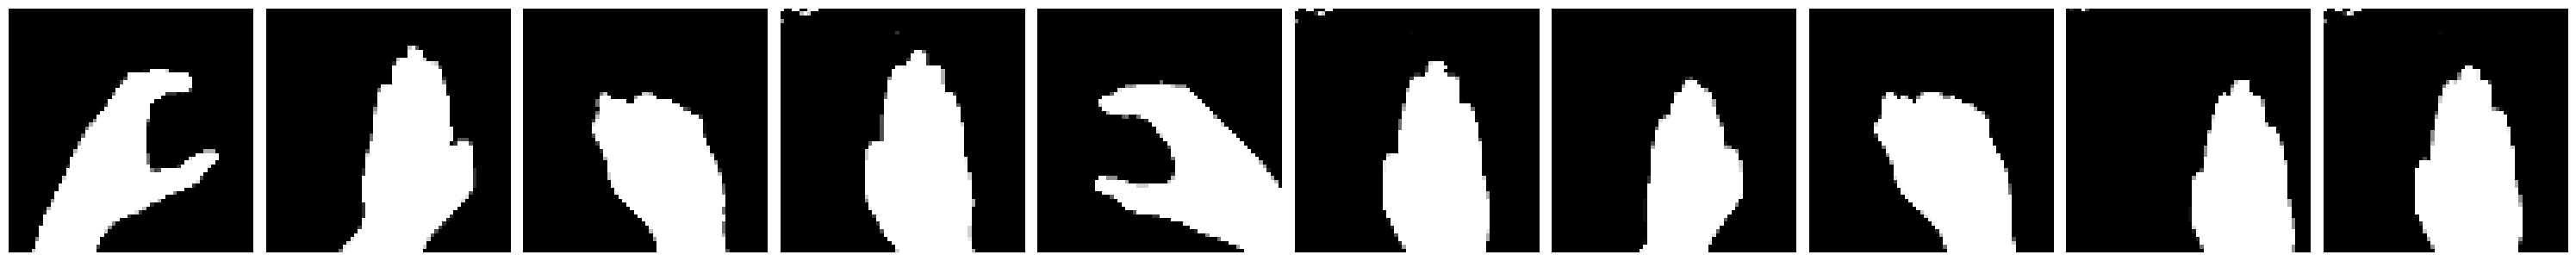

(2402, 64, 64, 3)
[[0 0 1]
 [0 1 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]


In [8]:
imgs = X_train
labels = y_train

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(imgs.shape)
print(labels)

In [10]:
word_dict = {0:'A', 1:'B', 2:'C'}
my_model = model()
my_model.load_weights('D:\\gesture\\weights\\weights-10-0.94.hdf5')

predictions = my_model.predict(X_test)
print('predictions on a small set of test data-- \n')
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end=' ')
    
plotImages(X_test)
print('\n')
print('Actual labels')
for i in y_test:
    print(word_dict[np.argmax(i)], end=' ')

19/19 [==============================] - 76s 4s/step
predictions on a small set of test data-- 

B B B B B A A C B A C C C B C B C A A B A B A B A B C B B A A A A B B B C C C C C C C C C B B B C C B A B B B C C B C A C B C C B C A A A C A A C A A C B B B B A A C A B C B C B C C C C B A C B B A A B B A C C A C C B B A A C C A C A A C B C C C A C C B B A B B C C C B B A A C B B A A A A C A C C B B B C C B B A A C A B C A A C C C A C B B A C A A C A A A B C B B A A B B B B C B B C A C A A C B A C C C C B C C B A A A B C B C B A A C A C C C B A C B C C B A C C C A C B B B C B A B C C B C A B C C A A A B B C B A A A C A B A B A C C B B B C C C A C A B C B A A C C C C C A B C C B C C A C B A A B C C C C B B C B C A B A C A B A A B A B B C A C B A A B A B C A C B C B A C A C C A B A C A B C C A C A C A C B A B A B B A B C B C B B C B A B C C C C B C A B B B A A B C B A C B C A C C B C A C B A A C B B B C C A A A C C C B B A B C C A B C C C B B B C A B B A A B A B B A A A B C B C C C C A B B B

NameError: name 'plotImages' is not defined

In [13]:
cam = cv2.VideoCapture(0)

num_frames = 0

while True:
    ret, frame = cam.read()
    
    frame = cv2.flip(frame, 1)
    
    frame_copy = frame.copy()
    
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    
    if num_frames < 70:
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, 'FETCHING BACKGROUND...PLEASE WAIT',
                    (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
                    
    else:
        hand = segment_hand(gray_frame)
        
        if hand is not None:
            
            thresholded, hand_segment = hand
            
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)],
                            -1, (255, 0, 0), 1)
            
            cv2.imshow("Thresholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,cv2.COLOR_GRAY2RGB)
            thresholded = np.expand_dims(thresholded, axis=0)
            
            pred = my_model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],
(500,200), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0,0,255), 2)
        
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.destroyWindow('Thresholded Hand Image')
            
            
            
            
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,125,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1
    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)
    # Closing windows with Esc key...(any other key with ord can be used too.)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Releasing the camera & destroying all the windows...
cv2.destroyAllWindows()
cam.release()

1/1 [==============================] - 1s 932ms/step
